In [1]:
import torch
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import optuna
import torchmetrics
import pytorch_lightning as pl
import torch.optim.lr_scheduler as lr_scheduler
import os

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [2]:
# Load the dataset
try:
    df = pd.read_csv("projects/kc_house_prices/data/kc_house_data.csv")
except FileNotFoundError:
    print("The file kc_house_data.csv was not found. Please ensure it's in the correct directory.")
    exit()

# Initial Data Inspection
print("--- Initial Data Info ---")
df.info()
print("\n--- First 5 Rows ---")
print(df.head())
print("\n--- Descriptive Statistics ---")
print(df.describe())
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Drop the 'id' column
if 'id' in df.columns:
    df = df.drop('id', axis=1)
    print("\nDropped 'id' column.")

print("\n--- Starting Preprocessing ---")

# 1. Date Feature Engineering
print("\n1. Processing 'date' column...")
df['date'] = pd.to_datetime(df['date'])
df['sale_year'] = df['date'].dt.year
df['sale_month'] = df['date'].dt.month
df['sale_dayofyear'] = df['date'].dt.dayofyear
df = df.drop('date', axis=1)
print("Extracted year, month, dayofyear from 'date' and dropped original.")

# 2. Age of House and Renovation Features
print("\n2. Engineering 'age' and renovation-related features...")
df['age_at_sale'] = df['sale_year'] - df['yr_built']
df['was_renovated'] = (df['yr_renovated'] > 0).astype(int)
df['yrs_since_renovation'] = np.where(df['was_renovated'] == 1,
                                      df['sale_year'] - df['yr_renovated'],
                                      0)
df['effective_age'] = df['sale_year'] - np.maximum(df['yr_built'], df['yr_renovated'].fillna(0)) # FillNa for yr_renovated if it can be NaN
print("Created 'age_at_sale', 'was_renovated', 'yrs_since_renovation', 'effective_age'.")

# 3. Boolean/Logical Features from sqft
print("\n3. Engineering boolean features from 'sqft' columns...")
df['has_basement'] = (df['sqft_basement'] > 0).astype(int)

# 4. Ratio Features
print("\n4. Engineering ratio features...")
df['sqft_living_per_bedroom'] = np.where(df['bedrooms'] > 0, df['sqft_living'] / df['bedrooms'], df['sqft_living'])
df['bathrooms_per_bedroom'] = np.where(df['bedrooms'] > 0, df['bathrooms'] / df['bedrooms'], df['bathrooms'])
df['sqft_living_per_floor'] = np.where(df['floors'] > 0, df['sqft_living'] / df['floors'], df['sqft_living'])
df.replace([np.inf, -np.inf], 0, inplace=True)
print("Created ratio features.")

# 5. Target Variable Transformation
print("\n5. Applying log transformation to 'price'...")
df['price_log'] = np.log1p(df['price'])
print("Created 'price_log'.")

# 6. Categorical Feature Encoding ('zipcode')
print("\n6. Encoding 'zipcode' using one-hot encoding...")
num_zipcodes = df['zipcode'].nunique()
print(f"Number of unique zipcodes: {num_zipcodes}")
if num_zipcodes > 50:
    print("Warning: Number of zipcodes is high. One-hot encoding will add many columns.")
df = pd.get_dummies(df, columns=['zipcode'], prefix='zip', dtype=int)
print(f"Applied one-hot encoding to 'zipcode'.")

# 7. Numerical Feature Scaling
print("\n7. Scaling numerical features...")
features_to_scale = df.select_dtypes(include=np.number).columns.tolist()
# Exclude one-hot encoded zip columns, boolean-like columns already 0/1, and target variables
zip_cols = [col for col in df.columns if col.startswith('zip_')]
boolean_like_cols = ['waterfront', 'was_renovated', 'has_basement']
target_cols = ['price', 'price_log']

features_to_scale = [
    col for col in features_to_scale
    if col not in zip_cols
    and col not in boolean_like_cols
    and col not in target_cols
]
print(f"Identified {len(features_to_scale)} features for scaling: {features_to_scale}")

if features_to_scale:
    scaler = StandardScaler()
    df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
    print("Applied StandardScaler to numerical features.")
else:
    print("No features identified for scaling.")

output_directory = "projects/kc_house_prices/data" 

# 2. Create the directory if it doesn't already exist
#    os.makedirs() will create any necessary parent directories as well.
#    exist_ok=True prevents an error if the directory already exists.
try:
    os.makedirs(output_directory, exist_ok=True)
    print(f"Ensured directory exists: '{output_directory}'")
except Exception as e:
    print(f"Error creating directory '{output_directory}': {e}")
    # Decide how to handle this error - perhaps save to current directory as a fallback or exit

# 3. Define the filename
output_filename = "kc_house_data_preprocessed.csv"

# 4. Combine the directory and filename to create the full path
full_output_path = os.path.join(output_directory, output_filename)

# 5. Save the DataFrame to the specified path
try:
    df.to_csv(full_output_path, index=False)
    print(f"\nPreprocessing complete. Processed data saved to: '{full_output_path}'")
except Exception as e:
    print(f"\nError saving the preprocessed data to CSV at '{full_output_path}': {e}")

--- Initial Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non

In [3]:
# Load the dataset
try:
    data = pd.read_csv("projects/kc_house_prices/data/kc_house_data_preprocessed.csv")
except FileNotFoundError:
    print("The file kc_house_data_preprocessed.csv was not found. Please ensure it's in the correct directory.")
    exit()

In [8]:
X = df.drop(columns=['price', 'price_log']) 
y = df['price_log']

X = torch.tensor(data=X.values, dtype=torch.float32)
y = torch.tensor(data=y.values, dtype=torch.float32)

X_train , X_test, y_train, y_test = train_test_split(X,
                                                     y,
                                                     test_size=0.3,
                                                     random_state=42) 


X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                y_test,
                                                test_size=0.5,
                                                random_state=42)

print("---------Data shapes---------")
print(f'X_train shape: {X_train.shape} | y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}    | y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}   | y_test shape: {y_test.shape}')

---------Data shapes---------
X_train shape: torch.Size([15129, 98]) | y_train shape: torch.Size([15129])
X_val shape: torch.Size([3242, 98])    | y_val shape: torch.Size([3242])
X_test shape: torch.Size([3242, 98])   | y_test shape: torch.Size([3242])


In [70]:
# creating the dataset with torch

class Kc_houseprices_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [71]:
# creating dataloaders with lightning

class KcHousePricesDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=16):
        super().__init__()
        self.batch_size = batch_size

    train_dataset = Kc_houseprices_Dataset(X_train, y_train)
    test_dataset = Kc_houseprices_Dataset(X_test, y_test)
    val_dataset = Kc_houseprices_Dataset(X_val, y_val)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

In [69]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.optim.lr_scheduler import ReduceLROnPlateau

class KcHousePrices(pl.LightningModule):

    def __init__(
        self,
        input_shape: int,
        hidden_units: int,
        num_layers: int,
        dropout: float,
        lr: float,
        weight_decay: float,
        lr_scheduler_patience: int = 3,
        lr_scheduler_factor: float = 0.1
    ):
        super().__init__()
        self.save_hyperparameters()

        layers = []
        layers.append(nn.Linear(input_shape, hidden_units))
        layers.append(nn.GELU())

        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))

        layers.append(nn.Linear(hidden_units, 1))

        self.model = nn.Sequential(*layers)
        self.loss_fn = nn.HuberLoss()

    def forward(self, x):
        return self.model(x).squeeze(1) # Output shape: [batch_size]

    def _common_step(self, batch, batch_idx, stage: str):
        x, log_y_true_batch = batch 
        
        log_y_hat = self(x) # Model output [batch_size]

        # Ensure log_y_true has same shape as log_y_hat for loss
        if log_y_true_batch.ndim == 2 and log_y_true_batch.shape[1] == 1:
            log_y_true = log_y_true_batch.squeeze(1)
        elif log_y_true_batch.ndim == 1:
            log_y_true = log_y_true_batch
        else:
            # Fallback or error for unexpected shape
            log_y_true = log_y_true_batch.squeeze() 


        loss = self.loss_fn(log_y_hat, log_y_true)

        safe_log_y = torch.where(
            torch.abs(log_y_true) < 1e-8,
            torch.ones_like(log_y_true) * 1e-8,
            log_y_true,
        )
        mape_log = torch.mean(torch.abs((log_y_hat - log_y_true) / safe_log_y)) * 100
        mae_log = torch.mean(torch.abs(log_y_hat - log_y_true))

        self.log(f"{stage}_loss", loss, on_step=(stage == "train"), on_epoch=True, prog_bar=True, sync_dist=True)
        # Only show log-space MAPE/MAE on progress bar if it's training, otherwise they are less interpretable
        self.log(f"{stage}_mape_log", mape_log, on_step=False, on_epoch=True, prog_bar=(stage == "train"), sync_dist=True)
        self.log(f"{stage}_mae_log", mae_log, on_step=False, on_epoch=True, prog_bar=(stage == "train"), sync_dist=True)

        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        x, log_y_true_batch = batch

        log_y_hat = self(x) # Model output [batch_size]

        if log_y_true_batch.ndim == 2 and log_y_true_batch.shape[1] == 1:
            log_y_true = log_y_true_batch.squeeze(1)
        elif log_y_true_batch.ndim == 1:
            log_y_true = log_y_true_batch
        else:
            log_y_true = log_y_true_batch.squeeze()

        # 1) Compute and log log‐space loss & metrics
        loss = self.loss_fn(log_y_hat, log_y_true)
        safe_log_y = torch.where(
            torch.abs(log_y_true) < 1e-8,
            torch.ones_like(log_y_true) * 1e-8,
            log_y_true,
        )
        mape_log = torch.mean(torch.abs((log_y_hat - log_y_true) / safe_log_y)) * 100
        mae_log = torch.mean(torch.abs(log_y_hat - log_y_true))

        self.log("val_loss", loss, prog_bar=True, on_epoch=True, sync_dist=True)
        self.log("val_mape_log", mape_log, prog_bar=False, on_epoch=True, sync_dist=True) # Not on prog bar
        self.log("val_mae_log", mae_log, prog_bar=False, on_epoch=True, sync_dist=True)  # Not on prog bar

        # 2) Exponentiate to get original price scale 
        price_pred = torch.expm1(log_y_hat)
        price_true = torch.expm1(log_y_true)

        mae_dollars = torch.mean(torch.abs(price_pred - price_true))
        safe_price_true = torch.where(
            price_true < 1e-8, 
            torch.ones_like(price_true) * 1e-8,
            price_true,
        )
        mape_dollars = torch.mean(torch.abs((price_pred - price_true) / safe_price_true)) * 100

        # Log USD‐space metrics 
        self.log("val_mae_dollars", mae_dollars, prog_bar=True, on_epoch=True, sync_dist=True)
        self.log("val_mape_dollars", mape_dollars, prog_bar=True, on_epoch=True, sync_dist=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, log_y_true_batch = batch

        log_y_hat = self(x) # Model output [batch_size]
        
        if log_y_true_batch.ndim == 2 and log_y_true_batch.shape[1] == 1:
            log_y_true = log_y_true_batch.squeeze(1)
        elif log_y_true_batch.ndim == 1:
            log_y_true = log_y_true_batch
        else:
            log_y_true = log_y_true_batch.squeeze()

        loss = self.loss_fn(log_y_hat, log_y_true)
        safe_log_y = torch.where(
            torch.abs(log_y_true) < 1e-8,
            torch.ones_like(log_y_true) * 1e-8,
            log_y_true,
        )
        mape_log = torch.mean(torch.abs((log_y_hat - log_y_true) / safe_log_y)) * 100
        mae_log = torch.mean(torch.abs(log_y_hat - log_y_true))

        self.log("test_loss", loss, prog_bar=True, on_epoch=True, sync_dist=True)
        self.log("test_mape_log", mape_log, prog_bar=False, on_epoch=True, sync_dist=True)
        self.log("test_mae_log", mae_log, prog_bar=False, on_epoch=True, sync_dist=True)

        price_pred = torch.expm1(log_y_hat)
        price_true = torch.expm1(log_y_true)

        mae_dollars = torch.mean(torch.abs(price_pred - price_true))
        safe_price_true = torch.where(
            price_true < 1e-8,
            torch.ones_like(price_true) * 1e-8,
            price_true,
        )
        mape_dollars = torch.mean(torch.abs((price_pred - price_true) / safe_price_true)) * 100

        # Log USD‐space metrics 
        self.log("test_mae_dollars", mae_dollars, prog_bar=True, on_epoch=True, sync_dist=True)
        self.log("test_mape_dollars", mape_dollars, prog_bar=True, on_epoch=True, sync_dist=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=self.hparams.lr_scheduler_factor,
            patience=self.hparams.lr_scheduler_patience,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss", # This monitors the log-space val_loss
                "interval": "epoch",
                "frequency": 1,
            },
        }

In [ ]:
import logging

def objective(trial):
    """Objective function to optimize with Optuna"""
     # --- 1. Suppress PyTorch Lightning's verbose internal logging ---
    # Set this at the beginning of each trial.
    # logging.INFO is default. logging.WARNING will show warnings and errors.
    # logging.ERROR will show only errors.
    logging.getLogger("pytorch_lightning").setLevel(logging.WARNING) 

    # --- 2. Suggest hyperparameters ---
    num_layers = trial.suggest_int('num_layers', 1, 5)
    hidden_units = trial.suggest_int("hidden_units", 64, 512, step=64)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    lr_scheduler_patience = trial.suggest_int('lr_scheduler_patience', 2, 5) 
    lr_scheduler_factor = trial.suggest_categorical('lr_scheduler_factor', [0.1, 0.2, 0.5])
    
    # --- 3. Create model ---
    model = KcHousePrices(
        input_shape=X_train.shape[1], # Ensure X_train is accessible
        hidden_units=hidden_units,
        num_layers=num_layers,
        dropout=dropout,
        lr=lr,
        weight_decay=weight_decay,
        lr_scheduler_patience=lr_scheduler_patience,
        lr_scheduler_factor=lr_scheduler_factor
    )

    # --- 4. Create DataModule ---
    data_module = KcHousePricesDataModule(batch_size=64)

    # --- 5. Define Callbacks with reduced verbosity ---
    callbacks_list = []
    early_stop_callback = EarlyStopping(
        monitor="val_loss", 
        patience=5, 
        mode="min", 
        verbose=False 
    )
    callbacks_list.append(early_stop_callback)

    # Define Trainer
    trainer = pl.Trainer(
        max_epochs=20,  
        logger=TensorBoardLogger("lightning_logs", name=f"trial_{trial.number}"),
        callbacks=callbacks_list,
        accelerator="cpu", # or "gpu"
        devices="auto",
        enable_progress_bar=False,    # Key: Disable progress bar
        enable_model_summary=False,   # Key: Disable model summary
    )

    # Train model
    trainer.fit(model, datamodule=data_module)

    # Return validation loss for Optuna to minimize
    return trainer.callback_metrics["val_loss"].item()

In [ ]:
def create_optuna_study(n_trials : int):
    study = optuna.create_study(direction="minimize")
    # You can also control Optuna's own verbosity:
    optuna.logging.set_verbosity(optuna.logging.WARNING) # Shows only Optuna warnings and errors
    optuna.logging.set_verbosity(optuna.logging.INFO) # Default, shows completion messages
    study.optimize(objective, n_trials=n_trials) # Or your desired number of trials
    print("\nStudy statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("Best hyperparameters:", study.best_params)
    print("Best value (min val_loss):", study.best_value)

create_optuna_study(n_trials=100)

[I 2025-06-03 00:21:18,439] A new study created in memory with name: no-name-ed8f8647-d361-4dea-906a-f9b28d8a6201
c:\Users\dania\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\dania\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
[I 2025-06-03 00:22:03,813] Trial 0 finished with value: 0.02848547324538231 and parameters: {'num_layers': 2, 'hidden_units': 64, 'dropout': 0.11792122290151325, 'lr': 0.0020808955973919082, 'weight_decay': 0.00595252

NameError: name 'exit' is not defined

In [ ]:
NUM_LAYERS = 2
HIDDEN_UNITS = 192
DROP_OUT = 0.13
LR = 2e-4
WEIGHT_DECAY = 1e-4
LR_SCHEDULER_PATIENCE = 4
LR_SCHEDULER_FACTOR = 0.5

# Paths
LOG_DIR = "lightning_logs"
CHECKPOINT_DIR = os.path.join(LOG_DIR, "checkpoints")

pl.seed_everything(seed=42, workers=True)

data_module = KcHousePricesDataModule(batch_size=64)

mlp_model = KcHousePrices(
                          input_shape=X_train.shape[1],
                          hidden_units=HIDDEN_UNITS,
                          num_layers=NUM_LAYERS,
                          dropout=DROP_OUT,
                          lr= LR,
                          weight_decay=WEIGHT_DECAY,
                          lr_scheduler_patience=LR_SCHEDULER_PATIENCE,
                          lr_scheduler_factor=LR_SCHEDULER_FACTOR
                          )

csv_logger = CSVLogger(save_dir=LOG_DIR, name="kc_house_mlp")

early_stop_callback = EarlyStopping(
                                    monitor='val_loss',
                                    patience=10,
                                    mode='min',
                                    verbose=True
                                    )
model_checkpoint_callback = ModelCheckpoint(
        dirpath=CHECKPOINT_DIR,
        filename='best-model-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1, # Save only the best model
        monitor='val_loss',
        mode='min',
        verbose=True
        )

lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')
callbacks = [early_stop_callback, model_checkpoint_callback, lr_monitor_callback]

trainer = pl.Trainer(max_epochs=200,
                     accelerator='auto', 
                     logger=csv_logger,
                     log_every_n_steps=5,
                     callbacks=callbacks)

trainer.fit(mlp_model ,data_module)

Seed set to 42


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [76]:
best_model_path = model_checkpoint_callback.best_model_path
if best_model_path:
    print(f"Loading best model from: {best_model_path}")
    test_results = trainer.test(model=mlp_model, datamodule=data_module, ckpt_path=best_model_path)
else:
    print("No best model checkpoint found. Testing with the last model state.")
    test_results = trainer.test(model=mlp_model, datamodule=data_module)
    
print(test_results)

Loading best model from: C:\Users\dania\vsproject\lightning_logs\checkpoints\best-model-epoch=82-val_loss=0.01.ckpt


c:\Users\dania\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.015190977603197098    │
│     test_mae_dollars      │       68725.7421875       │
│       test_mae_log        │    0.12581367790699005    │
│     test_mape_dollars     │    12.904524803161621     │
│       test_mape_log       │    0.9683186411857605     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.015190977603197098, 'test_mape_log': 0.9683186411857605, 'test_mae_log': 0.12581367790699005, 'test_mae_dollars': 68725.7421875, 'test_mape_dollars': 12.904524803161621}]


In [10]:
import glob
import seaborn as sns

def find_training_metrics_csv(main_run_directory_path: str, 
                              training_logs_subdir: str, 
                              version_folder_name: str):
    """
    Constructs the direct path to the metrics.csv file based on the known structure.
    """
    expected_metrics_path = os.path.join(
        main_run_directory_path, 
        training_logs_subdir, 
        version_folder_name, 
        "metrics.csv"
    )

    if os.path.exists(expected_metrics_path):
        print(f"Found metrics file: {expected_metrics_path}")
        return expected_metrics_path
    else:
        print(f"Metrics file not found at expected path: {expected_metrics_path}")
        print("Please verify the following paths and names in your plotting script:")
        print(f"  - MAIN_RUN_DIR_TO_PLOT: '{main_run_directory_path}'")
        print(f"  - TRAINING_LOGS_SUBDIR_NAME: '{training_logs_subdir}'")
        print(f"  - SEED_VERSION_NAME (folder name): '{version_folder_name}'")
        return None

def plot_training_validation_metrics(metrics_file_path):
    if metrics_file_path is None or not os.path.exists(metrics_file_path):
        print(f"Metrics file not found or path is None. Cannot generate plots.")
        return

    try:
        metrics_df = pd.read_csv(metrics_file_path)
    except Exception as e:
        print(f"Error loading metrics.csv: {e}")
        return

    print("\nAvailable columns in metrics.csv for plotting:")
    print(metrics_df.columns.tolist())
    
    if 'epoch' not in metrics_df.columns:
        print("Error: 'epoch' column not found. Cannot proceed.")
        return
    
    x_axis_col = 'epoch'

    try:
        plt.style.use('seaborn-v0_8-darkgrid')
    except OSError:
        print("Style 'seaborn-v0_8-darkgrid' not found. Trying 'ggplot'.")
        try:
            plt.style.use('ggplot')
        except OSError:
            print("Style 'ggplot' not found. Using Matplotlib default style with grid.")

    train_loss_col = 'train_loss_epoch' 
    val_loss_col = 'val_loss'          
    train_mape_log_col = 'train_mape_log'
    val_mape_log_col = 'val_mape_log'    
    train_mae_log_col = 'train_mae_log'  
    val_mae_log_col = 'val_mae_log'      
    val_mape_dollars_col = 'val_mape_dollars'
    val_mae_dollars_col = 'val_mae_dollars'  
    lr_col = next((col for col in metrics_df.columns if col.startswith('lr-')), None)

    # Plotting functions (Loss, MAPE log, MAE log, LR)
    # Example for Loss:
    if train_loss_col in metrics_df.columns and val_loss_col in metrics_df.columns:
        plot_df_train_loss = metrics_df[[x_axis_col, train_loss_col]].dropna()
        plot_df_val_loss = metrics_df[[x_axis_col, val_loss_col]].dropna()
        
        if not plot_df_train_loss.empty and not plot_df_val_loss.empty:
            plt.figure(figsize=(12, 7))
            plt.plot(plot_df_train_loss[x_axis_col], plot_df_train_loss[train_loss_col], label='Train Loss (Log-space)', linestyle='-')
            plt.plot(plot_df_val_loss[x_axis_col], plot_df_val_loss[val_loss_col], label='Validation Loss (Log-space)', linestyle='--')
            plt.xlabel(x_axis_col.capitalize()); plt.ylabel('Loss (Huber, Log-space)')
            plt.title('Training & Validation Loss (Log-Space) vs. Epoch'); plt.legend(); plt.grid(True); plt.tight_layout()
            plt.savefig("loss_log_space_plot.png"); plt.show()
        else: print(f"Not enough data for loss plot.")
    else: print(f"Loss columns not found: train='{train_loss_col}', val='{val_loss_col}'")

    # Add other plots similarly (MAPE log, MAE log, lr)
    # --- Plot MAPE (Log-Space) ---
    if train_mape_log_col in metrics_df.columns and val_mape_log_col in metrics_df.columns:
        plot_df_train_mape = metrics_df[[x_axis_col, train_mape_log_col]].dropna()
        plot_df_val_mape = metrics_df[[x_axis_col, val_mape_log_col]].dropna()
        if not plot_df_train_mape.empty and not plot_df_val_mape.empty:
            plt.figure(figsize=(12, 7))
            plt.plot(plot_df_train_mape[x_axis_col], plot_df_train_mape[train_mape_log_col], label='Train MAPE (Log-space %)', linestyle='-')
            plt.plot(plot_df_val_mape[x_axis_col], plot_df_val_mape[val_mape_log_col], label='Validation MAPE (Log-space %)', linestyle='--')
            plt.xlabel(x_axis_col.capitalize()); plt.ylabel('MAPE (Log-space %)')
            plt.title('Training & Validation MAPE (Log-Space) vs. Epoch'); plt.legend(); plt.grid(True); plt.tight_layout()
            plt.savefig("mape_log_space_plot.png"); plt.show()
        else: print(f"Not enough data for log-space MAPE plot.")
    else: print(f"Log-space MAPE columns not found: train='{train_mape_log_col}', val='{val_mape_log_col}'")

    # --- Plot MAE (Log-Space) ---
    if train_mae_log_col in metrics_df.columns and val_mae_log_col in metrics_df.columns:
        plot_df_train_mae = metrics_df[[x_axis_col, train_mae_log_col]].dropna()
        plot_df_val_mae = metrics_df[[x_axis_col, val_mae_log_col]].dropna()
        if not plot_df_train_mae.empty and not plot_df_val_mae.empty:
            plt.figure(figsize=(12, 7))
            plt.plot(plot_df_train_mae[x_axis_col], plot_df_train_mae[train_mae_log_col], label='Train MAE (Log-space)', linestyle='-')
            plt.plot(plot_df_val_mae[x_axis_col], plot_df_val_mae[val_mae_log_col], label='Validation MAE (Log-space)', linestyle='--')
            plt.xlabel(x_axis_col.capitalize()); plt.ylabel('MAE (Log-space)')
            plt.title('Training & Validation MAE (Log-Space) vs. Epoch'); plt.legend(); plt.grid(True); plt.tight_layout()
            plt.savefig("mae_log_space_plot.png"); plt.show()
        else: print(f"Not enough data for log-space MAE plot.")
    else: print(f"Log-space MAE columns not found: train='{train_mae_log_col}', val='{val_mae_log_col}'")
        
    # --- Plot Learning Rate ---
    if lr_col and lr_col in metrics_df.columns :
        epoch_aligned_lr_df = metrics_df[[x_axis_col, lr_col]].dropna()
        if not epoch_aligned_lr_df.empty:
            plt.figure(figsize=(10, 6))
            plt.plot(epoch_aligned_lr_df[x_axis_col], epoch_aligned_lr_df[lr_col], label='Learning Rate', marker='.', linestyle='-')
            plt.xlabel(x_axis_col.capitalize()); plt.ylabel('Learning Rate')
            plt.title('Learning Rate vs. ' + x_axis_col.capitalize()); plt.legend(); plt.grid(True); plt.tight_layout()
            plt.savefig("lr_plot.png"); plt.show()
        else: 
            print(f"\nNo direct epoch-aligned LR data for '{lr_col}'. Attempting step-based plot.")
            if 'step' in metrics_df.columns:
                step_lr_df = metrics_df[metrics_df[lr_col].notna()][['step', lr_col]]
                if not step_lr_df.empty:
                    plt.figure(figsize=(10, 6))
                    plt.plot(step_lr_df['step'], step_lr_df[lr_col], label='Learning Rate (vs. Step)', marker='.', linestyle='-')
                    plt.xlabel('Step'); plt.ylabel('Learning Rate'); plt.title('Learning Rate vs. Step')
                    plt.legend(); plt.grid(True); plt.tight_layout(); plt.savefig("lr_vs_step_plot.png"); plt.show()
                else: print(f"No non-NaN LR values with 'step' for '{lr_col}'.")
            else: print("The 'step' column not available for fallback LR plot.")
    else: print(f"Learning rate column (starting with 'lr-') not found: '{lr_col}'.")

Attempting to find metrics using MAIN_RUN_DIR_TO_PLOT: projects/kc_house_prices/logs/lightning_logs/kc_house_mlp_final_run_20250603_014431
Found metrics file: projects/kc_house_prices/logs/lightning_logs/kc_house_mlp_final_run_20250603_014431\train_logs\seed42\metrics.csv

Available columns in metrics.csv for plotting:
['epoch', 'lr-Adam', 'step', 'train_loss_epoch', 'train_loss_step', 'train_mae_log', 'train_mape_log', 'val_loss', 'val_mae_dollars', 'val_mae_log', 'val_mape_dollars', 'val_mape_log']
Style 'seaborn-v0_8-darkgrid' not found. Trying 'ggplot'.


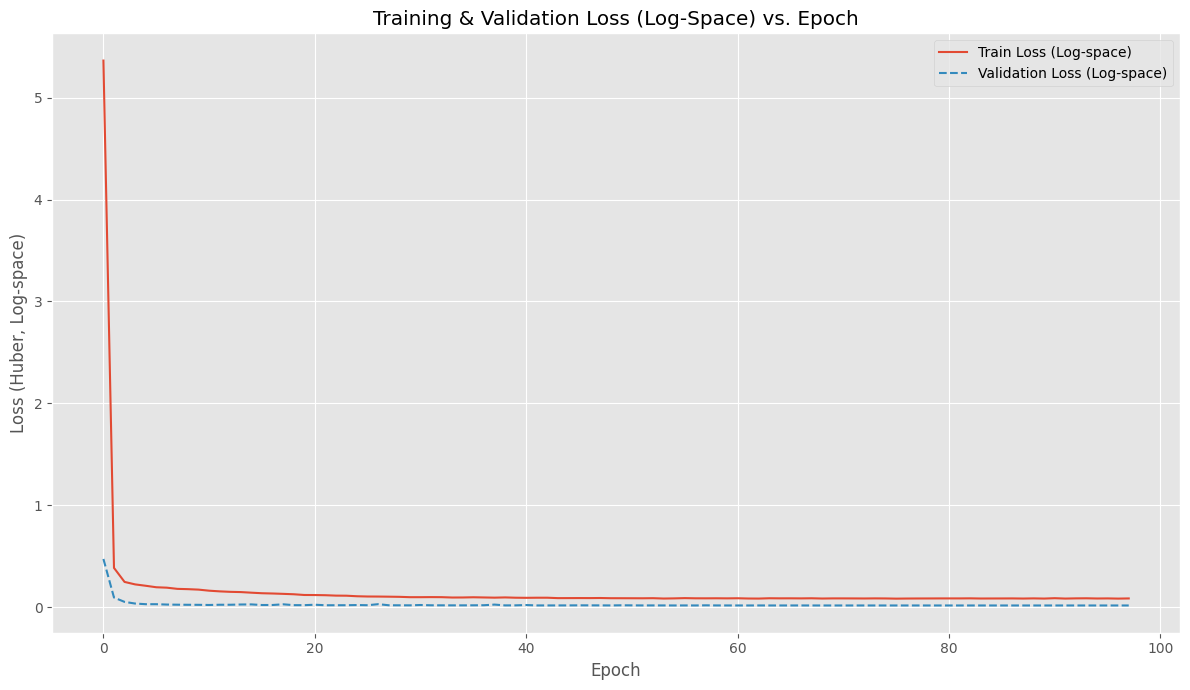

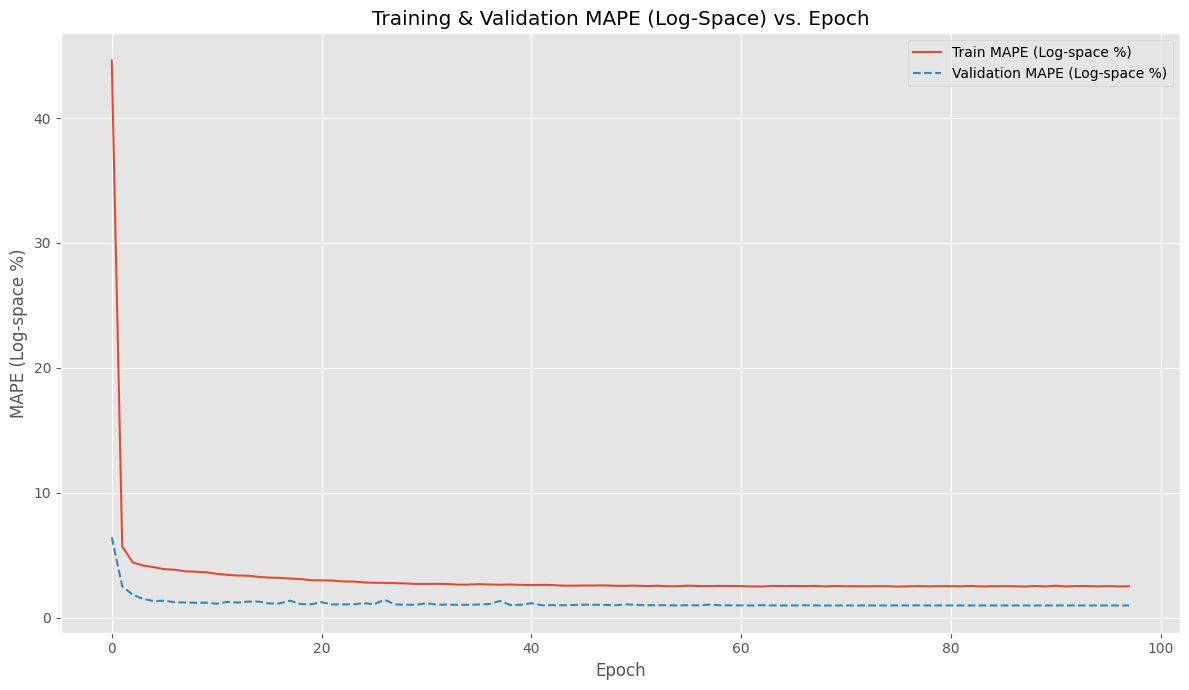

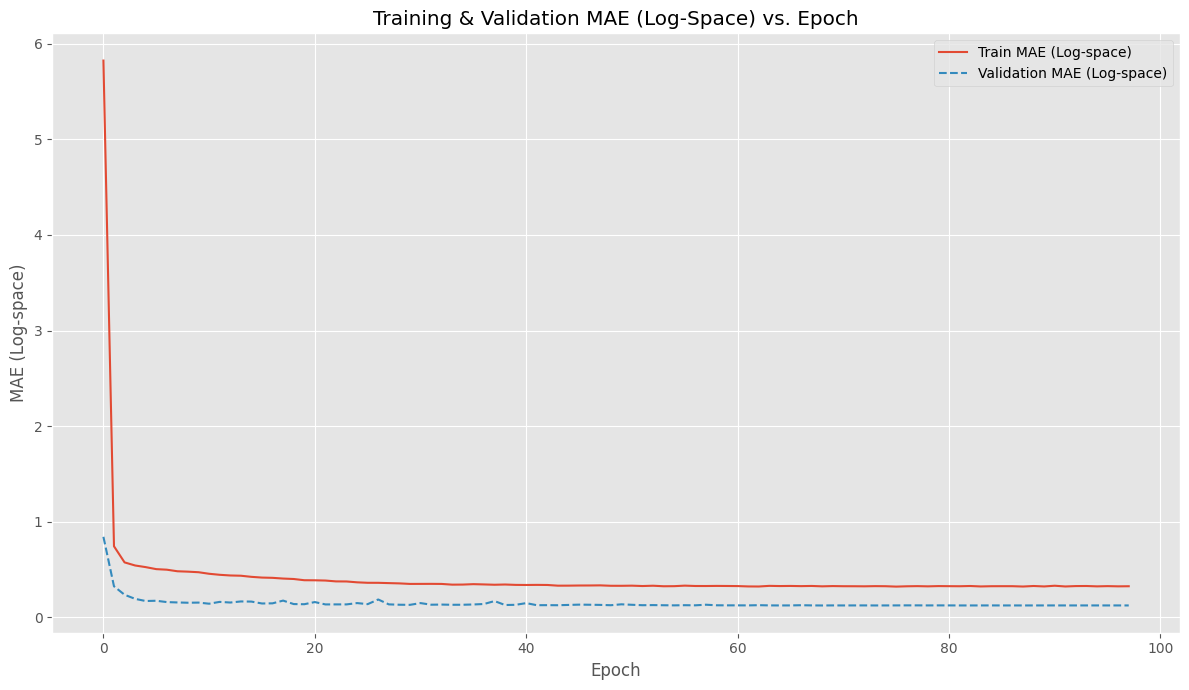


No direct epoch-aligned LR data for 'lr-Adam'. Attempting step-based plot.


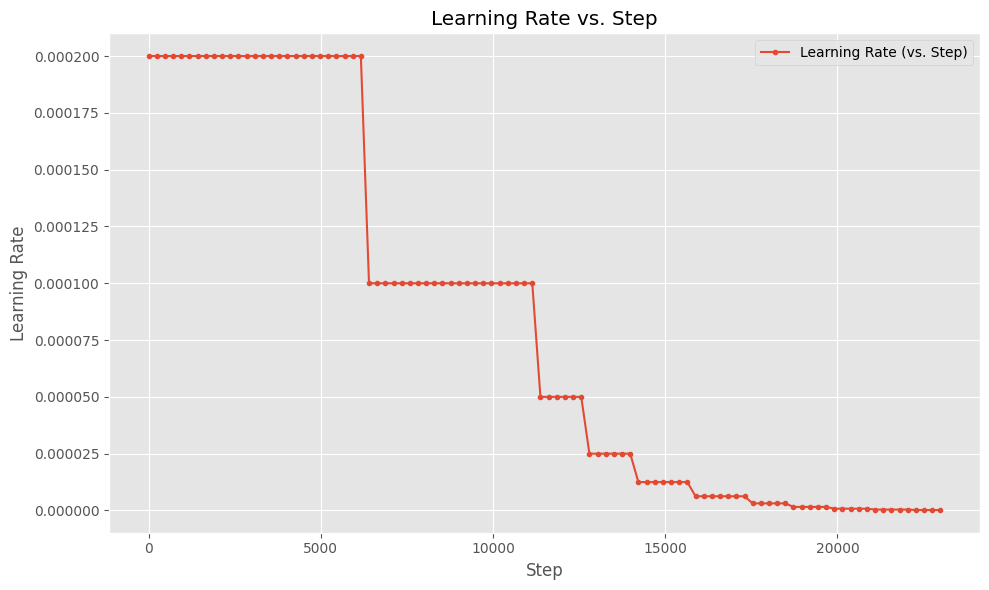

In [13]:
# METHOD 1: (RECOMMENDED FOR SIMPLICITY IF YOU KNOW THE RUN)
# Set the path to the specific main run directory you want to plot.
# This is the folder that CONTAINS 'train_logs', 'model_checkpoints', etc.
# Ensure this path is correct relative to where you run the plotting script, or use an absolute path.
MAIN_RUN_DIR_TO_PLOT = "projects/kc_house_prices/logs/lightning_logs/kc_house_mlp_final_run_20250603_014431"

TRAINING_LOGS_SUBDIR_NAME = "train_logs"
# This should match the SEED used in your train_final_model.py script for versioning the CSVLogger
SEED_VERSION_NAME = "seed42" 

# METHOD 2: (ALTERNATIVE - DIRECT PATH TO CSV)
# If you want to bypass the find function and point directly to the CSV.
# Uncomment and use this if Method 1 (using MAIN_RUN_DIR_TO_PLOT) gives trouble.
# DIRECT_METRICS_CSV_PATH = "projects/kc_house_prices/logs/lightning_logs/kc_house_mlp_final_run_20250603_014431/train_logs/seed42/metrics.csv"
DIRECT_METRICS_CSV_PATH = None # Set to None to use Method 1 by default

if DIRECT_METRICS_CSV_PATH and os.path.exists(DIRECT_METRICS_CSV_PATH):
    print(f"Using direct path to metrics.csv: {DIRECT_METRICS_CSV_PATH}")
    metrics_file_to_plot = DIRECT_METRICS_CSV_PATH
elif MAIN_RUN_DIR_TO_PLOT:
    print(f"Attempting to find metrics using MAIN_RUN_DIR_TO_PLOT: {MAIN_RUN_DIR_TO_PLOT}")
    metrics_file_to_plot = find_training_metrics_csv(
        main_run_directory_path=MAIN_RUN_DIR_TO_PLOT,
        training_logs_subdir=TRAINING_LOGS_SUBDIR_NAME,
        version_folder_name=SEED_VERSION_NAME 
    )
else:
    print("Please set either 'DIRECT_METRICS_CSV_PATH' or 'MAIN_RUN_DIR_TO_PLOT' at the top of the script.")

if metrics_file_to_plot:
    plot_training_validation_metrics(metrics_file_to_plot)
else:
    print("Could not find metrics.csv to plot. Please check your path configurations.")

In [ ]:
# with open('projects/kc_house_prices/src/model.py', 'w') as f:
#     f
    


In [80]:
os.mkdir('projects/logs/lightning_logs_final_model')